# Automatizce ve fyzice: PHYSBO

Petr Čermák  
2023-12-01

## Připojte se

{{< qrcode https://cermak.science/teaching/automation/lectures/08-physbo/presentation.html >}}

[cermak.science/teaching/automation/lectures/08-physbo/presentation.html](https://cermak.science/teaching/automation/lectures/08-physbo/presentation.html)

# Opakování

## Gaussovský proces

-   neparametrický model náhodného procesu
-   popisuje ho střední hodnota a kovarianční funkce

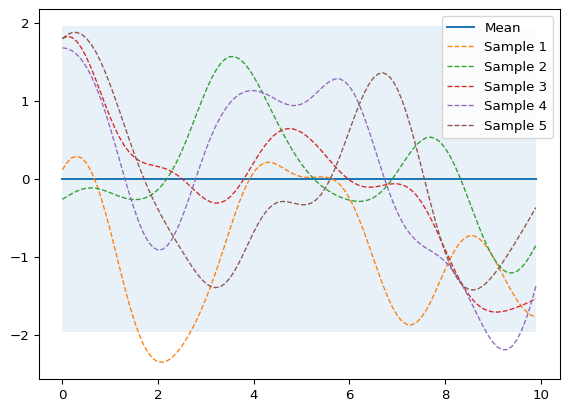

In [1]:
import numpy as np
from helper import plot_gp

def kernel(X1, X2, l=1.0, sigma=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1,2: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)


# Vygeneruji body (konečný počet)
X = np.arange(0, 10, 0.1).reshape(-1, 1) #počet sloupců dopočítá

mu = np.zeros(X.shape)   # střední hodnota
cov = kernel(X, X)       # spočtu kovarianci (nenormovaná korelace)

# Vygeneruji 5 funkcí jako výsledek náhodného gaussovského procesu
samples = np.random.multivariate_normal(mu.ravel(), cov, 5)

# Vykreslí střední hodnotu, oblast nejistoty a funkce 
plot_gp(mu, cov, X, samples=samples)

## Posterior

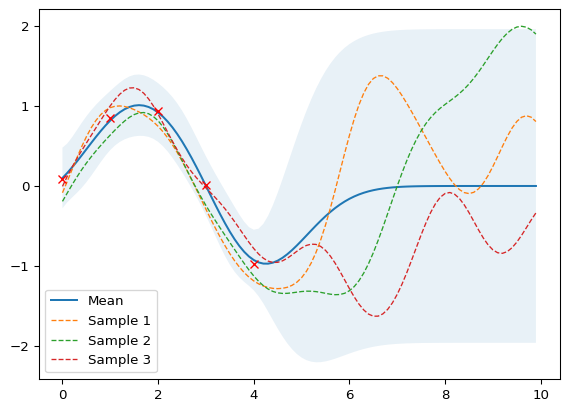

In [2]:
from numpy.linalg import inv

def posterior(X, X_train, Y_train, l=1.0, sigma=1.0, sigma_y=1e-8):
    """
    Spočítá novou střední hodnotu a kovarianci při znalosti train dat
    
    Args:
        X: osa x
        X_train, Y_train: známá data (m x 1)
        l, sigma: Parametry jádra
        sigma_y: šum
    
    Returns:
        Posterior střední hodnota (n x d) a kovariance (n x n).
    """
    K = kernel(X_train, X_train, l, sigma) + sigma_y**2 * np.eye(len(X_train))  # jádro s šumem
    K_s = kernel(X_train, X, l, sigma)
    K_ss = kernel(X, X, l, sigma) + 1e-8 * np.eye(len(X))
    
    # Equation (7)
    mu_s = K_s.T.dot(inv(K)).dot(Y_train)
    # Equation (8)
    cov_s = K_ss - K_s.T.dot(inv(K)).dot(K_s)
    return mu_s, cov_s


noise = 0.2
X_train = np.arange(0, 5, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)
mu_s, cov_s = posterior(X, X_train, Y_train, sigma_y=noise)
samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma^2 \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2l^2}\right)
$$

## Optimální parametry se musí fitovat

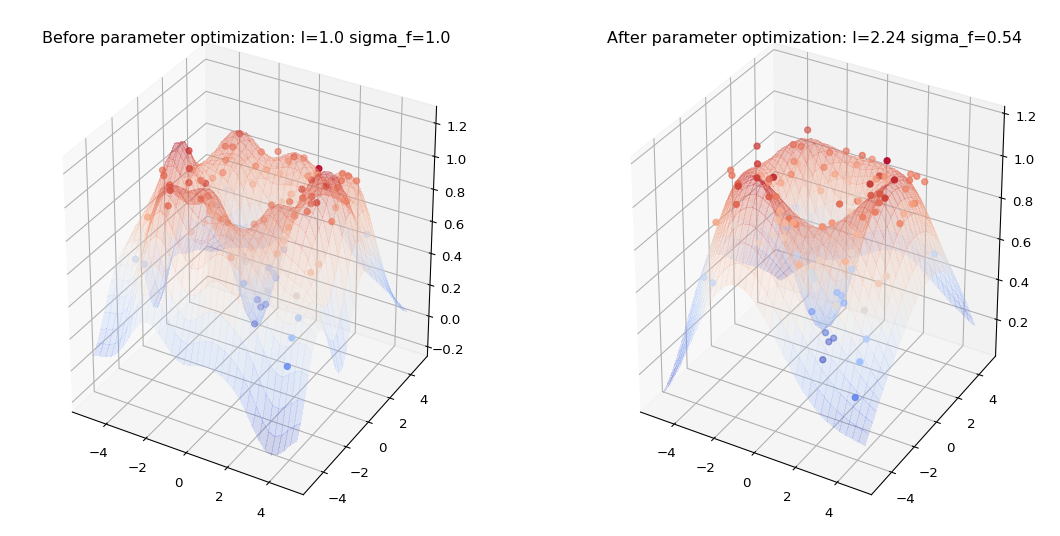

In [3]:
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize
from matplotlib import pyplot as plt

def nll_fn(X_train, Y_train, noise, naive=True):
    """
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given
    noise level.

    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        naive: if True use a naive implementation of Eq. (11), if
               False use a numerically more stable implementation.

    Returns:
        Minimization objective.
    """
    
    Y_train = Y_train.ravel()
    
    def nll_naive(theta):
        # Naive implementation of Eq. (11). Works well for the examples 
        # in this article but is numerically less stable compared to 
        # the implementation in nll_stable below.
        K = kernel(X_train, X_train, l=theta[0], sigma=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        return 0.5 * np.log(det(K)) + \
               0.5 * Y_train.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
        
    def nll_stable(theta):
        # Numerically more stable implementation of Eq. (11) as described
        # in http://www.gaussianprocess.org/gpml/chapters/RW2.pdf, Section
        # 2.2, Algorithm 2.1.
        
        K = kernel(X_train, X_train, l=theta[0], sigma=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        L = cholesky(K)
        
        S1 = solve_triangular(L, Y_train, lower=True)
        S2 = solve_triangular(L.T, S1, lower=False)
        
        return np.sum(np.log(np.diagonal(L))) + \
               0.5 * Y_train.dot(S2) + \
               0.5 * len(X_train) * np.log(2*np.pi)

    if naive:
        return nll_naive
    else:
        return nll_stable



from helper import plot_gp_2D

noise_2D = 0.1

rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (100, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

plt.figure(figsize=(14,7))

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, 
           f'Before parameter optimization: l={1.00} sigma_f={1.00}', 1)

res = minimize(nll_fn(X_2D_train, Y_2D_train, noise_2D), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

mu_s, _ = posterior(X_2D, X_2D_train, Y_2D_train, *res.x, sigma_y=noise_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After parameter optimization: l={res.x[0]:.2f} sigma_f={res.x[1]:.2f}', 2)

## Bayesovská optimalizace

Cíl: najít minimum za pomocí nejmenšího počtu měření

–\> Bayesovská optimalizace! Potřebujeme:

### Surrogate model

-   Gaussovský proces

### Akviziční funkce

-   hledá kompromis mezi
    -   *průzkumem* (exploration) - měřit tam, kde nic nevíme
    -   *vytěžováním* (exploitation) - měřit tom, kde se odhaduje
        minimum/maximum

# Optimalizační tooly

## PHYSBO

optimization tools for PHYsics based on Bayesian Optimization

-   Can handle much larger data than scikit-learn
-   Very easy and user firendly
-   Tutorials available

## Základní syntaxe

``` python
#| code-line-numbers: 5-8|10-17|19-21|22-23|24-26
import itertools, physbo, numpy as np

#muj rozsah promennych
xrange = np.linspace(-1,1,41)
yrange = np.linspace(-1,1,41)
X = np.array(list(itertools.product(xrange, yrange)))

#funkce
def centering(actions:int) -> float:
    action_idx = actions[0]
    _x = X[action_idx][0]
    _y = X[action_idx][1]
    maw(pos, [_x,_y,z()])
    count(5)        
    return roi1()[0]

# nastavit seed a oblast hledani
policy = physbo.search.discrete.policy(test_X=X)
policy.set_seed(0)
#nahoidne hledani (min. 2 vzorky)
res = policy.random_search(max_num_probes=10, simulator=centering())
#Bayesovske hledani
res = policy.bayes_search(max_num_probes=20, simulator=centering(), 
                          score='TS', interval=0, num_rand_basis=500)
```

## Přehled akvizičních funkcí

[Zde](https://issp-center-dev.github.io/PHYSBO/manual/master/en/_modules/physbo/search/score.html)

# Úkol #3

## Zadání

-   Existuje lanýžový les o rozloze 100x100m
-   Každý má k dispozici jedno virtuální prase
-   Kopání:
    -   je třeba určit praseti kde kopat (x,y)
    -   prase zjistí, kolik lanýžů je pod zemí (max 255)
-   Prase musí po kopání 5 minut odpočívat
-   Cíl: najít oblast s nejvyšší množstvím lanýžů
-   Cíl 2: prase každým kopáním stárne, chceme najít maximum a přitom
    prase co nejméně obtěžovat

## Jak na to?

-   získat vstupenku do lesa: napíšeme robotovi: `$get_forest_permit`

https://user.mgml.eu/forest/?x=XX&y=YY&permit=abcdef

-   vrátí to chybu (HTTP 500) nebo ok (code 200)